This is a demo for visualizing COVID-19 pandemic dataset from Johns Hopkins CSSE : https://github.com/CSSEGISandData/COVID-19


In [7]:
from ReadData import ReadData
from DictName import DictName
import urllib3
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import geoplot
import mapclassify

In [ ]:
# Download data from the github repo (data_url) and save to data_path
def download_data(data_path, data_url, verbose=1):
    http = urllib3.PoolManager()
    if verbose > 0:
        print('Downloading data file to ' + data_path + ' ...')
        with http.request('GET', data_url, preload_content=False) as resp, open('./', 'wb') as out:
            shutil.copyfileobj(resp, out)
        out.close()
        print('... done downloading data!')
    

In [8]:
# Download global data from github url
data_path = './git_data/'
data_url_root = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
filetypes = ['confirmed', 'deaths', 'recovered']
downloads = {}

for f in filetypes:
    downloads[f] = data_url_root + 'time_series_covid19_' + f + '_global.csv' 

if 0:
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    for f in downloads.keys():
        save_path = data_path + f + '.csv'
        url = downloads[f]
        download_data(data_path, url)

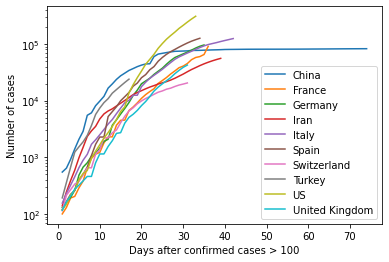

In [9]:
# Read local data

def read_file(read_path):
    d = ReadData(read_path)
    data = d.data
    data_country = data.drop(columns=['Lat', 'Long'])
    data_country =  data_country.groupby('Country/Region', axis=0).sum()
    coordinates = data.loc[:, ['Country/Region', 'Lat', 'Long']]
    # coordinates = coordinates.groupby('Country/Region').median()
    data_dict = {'metric': data_country,
                'coordinates': coordinates}

    return data_dict


def plot_time_series(data, fig_params):
    country_list = data.index
    legend_items = []
    fig, axis = plt.subplots()
    for c in country_list:
        y = data.loc[c]        
        y = y[y>=100]
        x = np.array(range(1, len(y)+1))  
        legend_items.append(c)
        axis.plot(x, y)
    axis.legend(legend_items)
    axis.set_xlabel(fig_params['xlabel'])
    axis.set_ylabel(fig_params['ylabel'])
    axis.set_yscale(fig_params['yscale'])



# Store data in dictionary
data_dict = {}
for ft in filetypes:
    path = data_path + ft + '.csv'
    data_dict[ft] = read_file(path)

confirmed = data_dict['confirmed']['metric']
deaths = data_dict['deaths']['metric']


# Plot confirmed cases in countries with confirmed cases > criteria on the last day
fig_params={'xlabel':'Days after confirmed cases > 100',
            'ylabel':'Number of cases',
            'yscale':'log'}
lastday = np.array(confirmed.keys())[-1]
confirmed_to_plot = confirmed[confirmed[lastday]>=20000]
deaths_to_plot = [] 

plot_time_series(confirmed_to_plot, fig_params)



In [10]:
# Calculate countries' daily accumulated confirmed cases and show on world map
def daily_data(data, cgeo, cdata, thisday):
    geo_confirm = np.zeros(cgeo.shape)
    for i, c in enumerate(cgeo):
        if c in cdata:
            case = data.loc[c, thisday]
            
        elif c in DictName.keys():
            # print('found',c, 'in dict') 
            case = data.loc[DictName[c][0], thisday]
        else:
            case = 0

        if case == 0:
            geo_confirm[i] = 0
        else:    
            geo_confirm[i] = np.log10(case)
            # geo_confirm[i] = case
    return geo_confirm

# Get data from geopandas
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
cgeo = np.array(world['name']) # country list from geopandas
cdata = np.array(data_dict['confirmed']['coordinates']['Country/Region'].unique()) # country list from dataset
data = data_dict['confirmed']['metric']
list_dates = np.array(data.keys())
last_day = list_dates[-1]

# use the last day's data as upper and lower limits for coloring polygons
geo_limits = daily_data(data, cgeo, cdata, list_dates[-1])

for i, day in enumerate(list_dates):
    img_path = './image/%03i'%i + '.png'
    geo_confirm = daily_data(data, cgeo, cdata, day)
    # scheme = mapclassify.EqualInterval(geo_limits, k=6)
    scheme = mapclassify.UserDefined(geo_limits, bins = np.arange(1, np.ceil(np.max(geo_limits))))
    geoplot.choropleth(
        world, hue=geo_confirm, scheme=scheme,
        legend=True, 
        legend_values=[0, 1, 2, 3, 4, 5],
        legend_labels=['<10', '(10,10^2]', '(10^2,10^3]', '(10^3,10^4]', '10^4,10^5', '>10^5'],
        legend_kwargs={'loc': 'lower left', 'bbox_to_anchor':(0., 0., 0.1, 0.3),'fontsize':8, 'title':'N confirmed cases',
        },
        cmap='Greens', figsize=(8, 5)
    )
    plt.title(day)
    
    if i<2:
             #         
      

SyntaxError: invalid syntax (<ipython-input-10-a4a31da6f3de>, line 51)

In [11]:
# under bash use command "convert -delay 10 -loop 1 *.png m.gif"
# show saved .gif
from IPython.display import HTML
HTML('<img src="./image/m.gif">')